In [27]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import os, logging, glob
from _dataset import dataset
from _logging import set_logging
from _utility import get_perc, get_dictionaries_from_list
from _pckle import save_pickle_object, load_pickle_object

set_logging(logging)
filename = "cats_dogs_model"
model = load_pickle_object(filename)
filename = "cats_dogs_X_test"
X_test = load_pickle_object(filename)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_folder = "cats_dogs_small"

2023-01-24 22:04:51,621 | INFO : Loading pickle file from: pickle\cats_dogs_model
2023-01-24 22:04:51,819 | INFO : Loading pickle file from: pickle\cats_dogs_X_test


In [28]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 1

In [29]:
classes = ["cat", "dog"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)
test_data = dataset(X_test, dict_classes, IMAGE_SIZE, logging)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

In [30]:
model.eval()
df_check_model_data = pd.DataFrame(columns = ["image_path", "prediction", "gt_label", "pred_label"])
with torch.no_grad():
    for i, (image, label_) in enumerate(test_loader):
        gt_label = label_[0].item()
        image = image.to(device)
        image_path = X_test[i]
        preds = model(image)
        prediction_ = torch.sigmoid(preds)[:, 1]
        prediction = prediction_[0].item()
        pred_label = dict_classes["cat"] if prediction < 0.5 else dict_classes["dog"]
        row = [image_path, prediction, gt_label, pred_label]
        df_check_model_data.loc[len(df_check_model_data.index)] = row


In [31]:
df_check_model_data.head(20)


,image_path,prediction,gt_label,pred_label
0,cats_dogs_small\data\test\dog\dog.7490.jpg,0.606578,1,1
1,cats_dogs_small\data\test\dog\dog.6764.jpg,0.554222,1,1
2,cats_dogs_small\data\test\cat\cat.1540.jpg,0.587631,0,1
3,cats_dogs_small\data\test\cat\cat.7580.jpg,0.412828,0,0
4,cats_dogs_small\data\test\cat\cat.7956.jpg,0.352357,0,0
5,cats_dogs_small\data\test\cat\cat.11028.jpg,0.606704,0,1
6,cats_dogs_small\data\test\dog\dog.7735.jpg,0.684605,1,1
7,cats_dogs_small\data\test\dog\dog.4195.jpg,0.606543,1,1
8,cats_dogs_small\data\test\cat\cat.6621.jpg,0.602371,0,1
9,cats_dogs_small\data\test\dog\dog.11883.jpg,0.412253,1,0


In [32]:
df_check_model_data.tail(20)

,image_path,prediction,gt_label,pred_label
104,cats_dogs_small\data\test\cat\cat.2334.jpg,0.366580,0,0
105,cats_dogs_small\data\test\cat\cat.11483.jpg,0.347888,0,0
106,cats_dogs_small\data\test\dog\dog.203.jpg,0.583816,1,1
107,cats_dogs_small\data\test\dog\dog.11998.jpg,0.533511,1,1
108,cats_dogs_small\data\test\dog\dog.8043.jpg,0.438616,1,0
109,cats_dogs_small\data\test\cat\cat.9768.jpg,0.416934,0,0
110,cats_dogs_small\data\test\cat\cat.6725.jpg,0.663526,0,1
111,cats_dogs_small\data\test\dog\dog.3838.jpg,0.515694,1,1
112,cats_dogs_small\data\test\dog\dog.3574.jpg,0.672857,1,1
113,cats_dogs_small\data\test\dog\dog.7644.jpg,0.672116,1,1


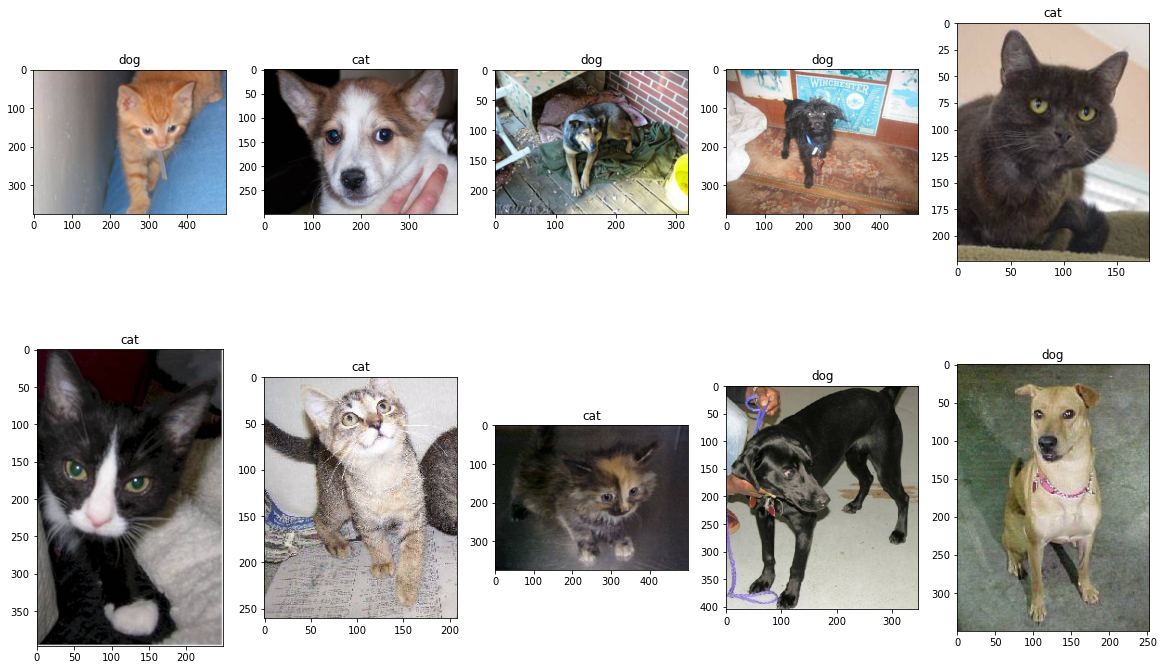

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        break    
    image_path = random.choice(df_check_model_data['image_path'].values)
    
    label = df_check_model_data.loc[df_check_model_data['image_path'] == image_path, 'pred_label'].values[0]
        
    img = Image.open(image_path)
    
    ax.set_title(dict_classes_rev[label])
    ax.imshow(img)


In [34]:
criterion = nn.CrossEntropyLoss()
test_accuracy = 0
test_loss = 0
for data, label in test_loader:
    data = data.to(device)
    label = label.to(device)
    
    test_output = model(data)
    loss = criterion(test_output,label)
    
    
    acc = ((test_output.argmax(dim=1) == label).float().mean())
    test_accuracy += acc/ len(test_loader)
    test_loss += loss/ len(test_loader)
    
print(f'test_accuracy : {test_accuracy}, test_loss : {test_loss}')

test_accuracy : 0.6935478448867798, test_loss : 0.5414873361587524
